In [2]:
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
!pip install control
from control import *
sp.init_printing()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


digital - 29.svg

**Item (a)** - Vamos resolver com equivalente mapeamento. 

Vamos relembrar: no equivalente mapeamento, colocamos no equivalente discreto $\hat{G}(z)$ um (e somente um) polo discreto para cada polo analógico que tivermos. Se o sistema tiver zeros explícitos, também podemos mapear um pra um da mesma forma. O polo ou zero discreto $z$ é calculado em função do analógico correspondente $s$ e do período de amostragem usando 
\begin{align}
  z &= e^{sT}
\end{align}

Para melhorar a aproximação, podemos adicionar zeros discretos em $-1$. Pode-se adicionar esses à vontade, desde que no final, o número de zeros totais não ultrapasse o número de polos.

A última parte do equivalente mapeamento é achar o ganho da função $\hat{G}(z)$. Esse ganho é achado igualando ao ganho em regime  do analógico com o do discreto. Lembre-se que o ganho em regime é calculado removendo-se os integradores, se existirem.



Ok, então, no nosso problema, temos um sistema analógico com um integrador e um pólo em $-100$. Nossa função discreta então pode ser:
\begin{align}
\hat{G}(z) &=\frac{A(z+1)^n}{(z-1)(z-\alpha)}
\end{align}
onde $n$ pode ser no máximo igual a $2$. No caso, $(z-1)$ corresponde ao integrador, isto é, o polo $s=0$. O polo em $\alpha$ corresponde ao polo analógico em $-100$, que é calculado como:
\begin{align}
  \alpha &= e^{-100\cdot 0.01} = e^{-1}
\end{align}
lembrando que nosso período de amostragem é $T=0.01$ (foi dado). Para simplificar nossas contas, vamos usar $n-0$. 

In [3]:
T=0.01
z = sp.symbols('z')
s = sp.symbols('s')
A = sp.symbols('A', real=True,positive=True)
K = sp.symbols('K', real=True,positive=True)
alpha = sp.exp(-100*T)
Gz = A/((z-1)*(z-alpha))

Para achar o valor de $A$ precisamos igualar os ganhos de regime dos sistemas analógico e digital. O ganho analógico é calculado como o valor da função em $s=0$, enquanto que o ganho digital em $z=1$, **removidos os integradores**. Neste caso:
\begin{align}
\left.\frac{A}{z-0.368}\right|_{z=1} &= \left.\frac{20000}{s+100}\right|_{s=0}\\
\end{align}

Resolvendo:

In [4]:
A = 200*(1-0.368)
A

Assim temos o equivalente discreto

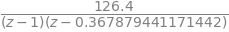

In [5]:
Gz = A/((z-1)*(z-alpha))
Gz

**Item (b)** - O problema não deixa claro, mas para ele pedir faixa de ganho é porque precisamos introduzir um ganho proporcional na malha, $K$. Para a faixa de ganho, vamos aplicar Routh, fazendo a volta para o analógico usando Tustin inverso. Lembre-se que:
\begin{align}
z = \frac{2+Ts}{2-Ts}
\end{align}

Substituindo e usando a função factor() para melhorar o visual do resultado temos:

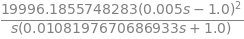

In [6]:
Gs = Gz.subs(z,(2+T*s)/(2-T*s)).factor()
Gs

Agora, calculando o polinomio de malha fechada, como ganho $K$ vamos ter:

In [7]:
pmf = sp.numer(sp.simplify(1+K*Gs))
pmf

Expandindo e coletando em relação a $s$:

In [8]:
pmf=pmf.expand().collect(s)
pmf

Esses números estão bem ruins de trabalhar, podemos fazer alguns arredondamentos. Assim, vamos considerar que o polinômio seja:
\begin{align}
20000K + s^2(0.5K+0.011)+s(1-200K)
\end{align}

Precisamos montar uma tabela de Routh agora, porém esses números são muito grandes para digitar um por um. Nesse caso, vou imprimir a expressão rapidamente para poder usar ctrl+c e ctrl+v

In [9]:
sp.latex(pmf)

'19996.1855748283 K + s^{2} \\left(0.499904639370707 K + 0.0108197670686933\\right) + s \\left(1.0 - 199.961855748283 K\\right)'

Agora, vamos montar a tabela Routh . Para um polinomio de 2a ordem é muito simples, pois a primeira coluna é simplesmente os coeficientes em ordem decrescente:
\begin{align}
\begin{array}{c|cc}
s^2 & 0.5 K + 0.011 & 20000K\\
s^1 & 1-200K & 0\\
s^0 & 20000K
\end{array}
\end{align}

Para todas as raízes no SPE, toda a primeira coluna não pode mudar o sinal. Supondo que o $K$ tenha que ser positivo (é quase sempre o caso), temos:
\begin{align}
0.5K+0.011 &>0 ⇒ K > -0.022\\
1-200K &>0 ⇒ K<1/200\\
20000K &>0 ⇒ K > 0
\end{align}

Então nossa faixa de estabilidade é $0<K<0.005$

**Item (c)** - Para termos um overshoot de 15%, o amortecimento deve ser:
\begin{align}
  ξ = \frac{-\log (M_p)}{\sqrt{\pi^2+(\log (M_p))^2 }}
\end{align}

In [10]:
Mp = 0.15
xi = -np.log(Mp)/np.sqrt(np.pi**2 + np.log(Mp)**2)
xi

Uma coisa que torna esse problema um pouco complicado e diferente do usual é que as especificações de projeto não deram um segundo critério (normalmente tempo de acomodação), para podermos tirar uma frequência natural. Se o problema tivesse dado, os próximos passos seriam: (1) determinar os polos analógicos; (2) mapear os polos para o plano Z; (3) construir o polinômio de MF desejado em Z; (4) igualar coeficientes e resolver o ganho.


Temos duas formas de resolver a situação. podemos fazer um LGR do sistema discreto e ver onde ele corta a linha espiral de amortecimento aproximadamente igual a 0.5 (que acabamos de calcular). Aí vemos qual ganho aproximadamente ele fornece.

Outra forma é tentar resolver analiticamente.

**Método 1** - Primeiro fazemos o LGR do sistema que discretizamos. 

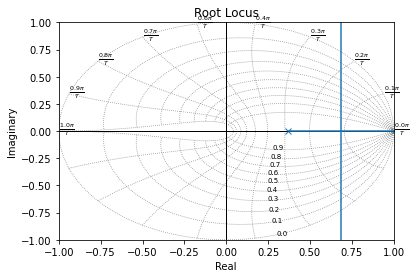

In [11]:
num = 126.4
den = np.convolve([1,-1],[1,-0.368])
sys = TransferFunction(num,den,0.01)
r,k=rlocus(sys)
g = plt.gca()
g.axis('auto')      ## Essa linha é neessária porque o zoom do gráfico q ele gera automaticamente fica muito ruim
g.set_xlim(-1,1)
g.set_ylim(-1,1)
plt.show()
#g.axis.xlim([-1,1])    ## Usamos essas linhas para deixar o LGR mais visivel em relação ao circulo unitário
#g.axis().ylim([-1,1])
#g.
#g.axis.xlim

Vemos que o nosso LGR passa realmente pela linha de amortecimento 0.5. O ideal seria dar um zoom no gráfico e ver mais ou menos onde a linha do LGR toca na linha de amortecimento, porém, não consegui descobrir uma forma adequada de fazer isso aqui no Colab. Assim, vamos ter q nos contentar com uma solução bem aproximada ;(

Bem, o próximo passo é descobrir quanto vale o ganho para as raízes onde acontece a intersecção entre o LGR e a linha de amortecimento 0.5. O vetor "k" resultante da função rlocus() contém todos os ganhos para cada raiz calculada. Vemos que a intersecção acontece quando a parte imaginária das raízes é aproximadamente $\pm 0.3$. Sendo assim, temos que localizar as raízes cuja parte imaginária é aproximadamente isso e verificar qual ganho a gerou.

Isso não é muito trivial de fazer, porque todas as informações aqui são aproximadas. Fizemos uma suposição aproximada para a parte imaginária e as raizes que a rlocus() calculou não tem exatamente a parte imaginária q estamos procurando. Precisamos fazer uma busca aproximada então.

Para fazer uma busca aproximada precisamos encontrar no vetor de raízes, aquela cuja parte imaginária está "próxima" de -0.3. Próxima significa que o erro entre o valor presente no vetor e o valor desejado está dentro de uma tolerância. Isso é expresso como:

\begin{align}
  |ℑ\{z\}-(-0.3)| < ϵ
\end{align}

onde $ϵ$ é um número suficientemente pequeno e $ℑ$ denota parte imaginária da raiz.


In [12]:
epsilon = 0.029
loc = abs(np.imag(r[:,1])-(-0.3)) < epsilon
loc

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

O vetor "loc" tem o mesmo número de elementos que o vetor de raízes e ganhos. Ele contém apenas valores lógicos. Cada elemento diz se a raiz testada se enquadra no critério. Ele vai ser praticamente todo falso, exceto em uns poucos (idealmente apenas um) elementos, que vão satisfazer nosso critério de busca. 

In [13]:
k[loc]

array([0.00164449])

Se passarmos o vetor "loc" de booleanos como índice para a matriz de ganhos, o console vai retornar apenas os elementos da matriz onde índice é verdadeiro. No nosso caso, ele retornou apenas um elemento, q é aquele que satisfaz a raiz que estamos procurando, no caso $K=0.0016$. 

Podemos melhorar esse resultado utilizando valores mais precisos de ganho na hora de montar o LGR. Também ajudaria se pudéssemos dar um zoom melhor no gráfico para identificar qual é a parte imaginária verdadeira do polo na intersecção das linhas